# ターボファンエンジンの診断システム構築

## 目的
- ターボファンエンジンの診断システムを構築する
    - システムの機能：
        - エンジンの現状把握（センサーデータの可視化）
        - 故障までのデータがない場合、異常検知手法も用いてエンジンの状態警告モデル
        - 故障までのデータがある場合、エンジンの状態を分類するモデル
        - 故障までのデータがある場合、エンジンの残存耐用期間（RUL）予測モデル

## このノートブックの目的
- 故障までのデータがある場合、エンジンの状態を分類するモデル構築

## インポート

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import japanize_matplotlib
import seaborn as sns
from pathlib import Path

In [11]:
# pandasの設定
pd.set_option('display.max_columns',  50)
pd.set_option('display.max_rows', 100)

# 図の設定
mpl.rc('axes', titlesize=18)
mpl.rc('axes', labelsize=16)
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)
mpl.rc('xtick', direction='in')
mpl.rc('ytick', direction='in')
mpl.rc('legend', fontsize=16)

# 図のサイズ
FIGURE_HEIGHT = 5
FIGURE_WIDTH = 5 * 1.414

# 色の設定
from cycler import cycler
import matplotlib.colors as mcolors
colors = mcolors.TABLEAU_COLORS
mpl.rcParams['axes.prop_cycle']  = cycler(color = [c for c in colors.values()])

## データ読み込み

In [2]:
data_dir = Path("../data/CMaps")
train_raw_dir = data_dir / "train_FD001.txt"
test_raw_dir = data_dir / "test_FD001.txt"
rul_raw_dir = data_dir / "RUL_FD001.txt"

In [3]:
# adding columns' name
variable_names = ['Unit','Time', 'setting_1', 'setting_2', 'setting_3',
                  'FanInletTemp', 'LPCOutletTemp', 'HPCOutletTemp', 'LPTOutletTemp', 'FanInletPres', 
                  'BypassDuctPres', 'TotalHPCOutletPres','PhysFanSpeed','PhysCoreSpeed', 'EnginePresRatio', 
                  'StaticHPCOutletPres', 'FuelFlowRatio', 'CorrFanSpeed', 'CorrCoreSpeed', 'BypassRatio',
                  'BurnerFuelAirRatio','BleedEnthalpy', 'DemandFanSpeed', 'DemandCorrFanSpeed', 'HPTCoolantBleed', 
                  'LPTCoolantBleed']

In [4]:
train_df = pd.read_csv(train_raw_dir, 
                    sep='\s+', 
                    header=None,
                    index_col=False,
                    names=variable_names)
train = train_df.copy()

test_df = pd.read_csv(test_raw_dir, 
                    sep='\s+', 
                    header=None,
                    index_col=False,
                    names=variable_names)
test = test_df.copy()

y_test = pd.read_csv(rul_raw_dir, 
                     sep='\s+', 
                     header=None,
                     index_col=False,
                     names=['RUL'])

## エンジン状態ラベル付ける

- 各エンジンユニットの残りのサイクルを追加

In [5]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="Unit")
    max_cycle = grouped_by_unit["Time"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='Unit', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["Time"]
    result_frame["RUL"] = - remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

In [6]:
# another method to add remaining cycle
# train["Remained_cycles"] =  - (train.groupby("Unit")["Time"].transform("max") - train["Time"])
# test["Remained_cycles"] =  - (train.groupby("Unit")["Time"].transform("max") - train["Time"])

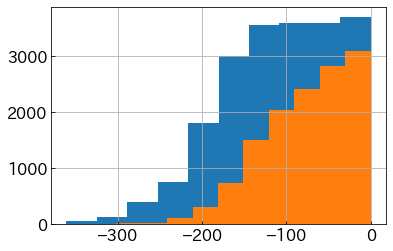

In [12]:
train = add_remaining_useful_life(train)
test = add_remaining_useful_life(test)
train["RUL"].hist()
test["RUL"].hist();

In [13]:
# エンジンの状態ラベル付
def add_condition_label(time_cycle):
    if time_cycle >= -50:
        return "urgent"
    elif time_cycle >= -125:
        return "short"
    elif time_cycle >= -200:
        return "medium"
    else:
        return "long"

In [14]:
train["EngineCondition"] = train['RUL'].apply(lambda x: add_condition_label(x))
test["EngineCondition"] = test['RUL'].apply(lambda x: add_condition_label(x))

In [15]:
train["EngineCondition"].value_counts(normalize=True) * 100

short     36.353061
medium    29.436285
urgent    24.720081
long       9.490572
Name: EngineCondition, dtype: float64

In [16]:
test["EngineCondition"].value_counts(normalize=True) * 100

short     43.158216
urgent    38.378131
medium    16.608125
long       1.855528
Name: EngineCondition, dtype: float64

In [17]:
# choose only sensors cotainings signal information
selected_sensors = ['LPCOutletTemp', 'HPCOutletTemp', 'LPTOutletTemp', 'TotalHPCOutletPres', 
                    'PhysFanSpeed', 'PhysCoreSpeed', 'StaticHPCOutletPres', 'FuelFlowRatio', 'CorrFanSpeed', 
                    'CorrCoreSpeed', 'BypassRatio', 'BleedEnthalpy', 'HPTCoolantBleed', 'LPTCoolantBleed']
useful_indexes = ['RUL', "Time", 'EngineCondition']

In [18]:
train[selected_sensors + useful_indexes].head()

,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,TotalHPCOutletPres,PhysFanSpeed,PhysCoreSpeed,StaticHPCOutletPres,FuelFlowRatio,CorrFanSpeed,CorrCoreSpeed,BypassRatio,BleedEnthalpy,HPTCoolantBleed,LPTCoolantBleed,RUL,Time,EngineCondition
0,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,-191,1,medium
1,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,-190,2,medium
2,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,-189,3,medium
3,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,-188,4,medium
4,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,-187,5,medium


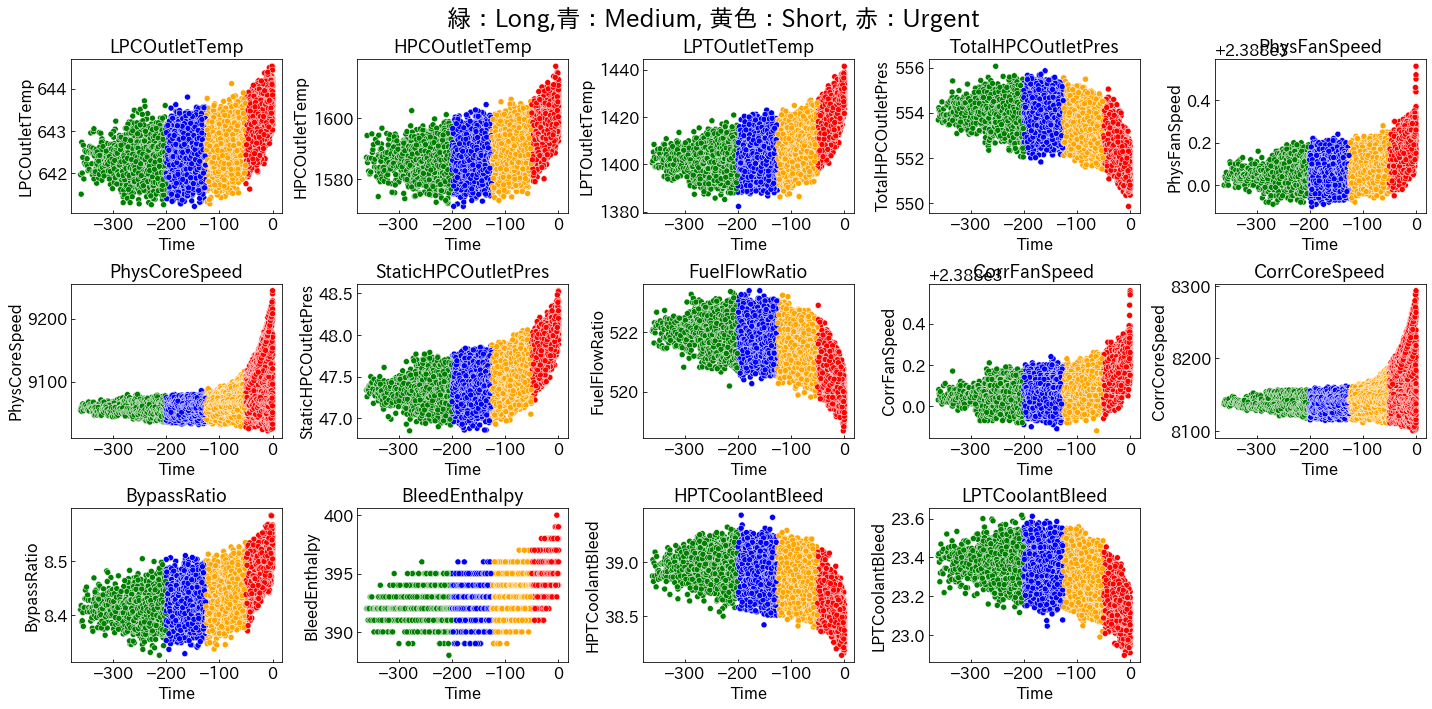

In [26]:
# prepare data
plot_data = train[selected_sensors + useful_indexes]

# plotting
num_rows = 3
num_cols = 5
fig = plt.figure(figsize=(20,10))
fig.suptitle("緑：Long,青：Medium, 黄色：Short, 赤：Urgent ", fontsize=24)
for index, sensor in enumerate(selected_sensors):
    ax = fig.add_subplot(num_rows, num_cols, index + 1)
    sns.scatterplot(x="RUL", y=sensor, data=plot_data, hue="EngineCondition", ax=ax, legend=False, 
                    palette=["blue","orange","red","green"])
    ax.set_xlabel("Time")
    # ax.set_xlim([400,0])
    ax.set_title(sensor)

fig.tight_layout()

In [27]:
training_set_df = pd.DataFrame()
training_set_df["Count"] = train["EngineCondition"].value_counts()
training_set_df["Percent (%)"] = train["EngineCondition"].value_counts(normalize=True).round(2) * 100

In [28]:
training_set_df

,Count,Percent (%)
short,7500,36.0
medium,6073,29.0
urgent,5100,25.0
long,1958,9.0


In [29]:
test_set_df = pd.DataFrame()
test_set_df["Count"] = test["EngineCondition"].value_counts()
test_set_df["Percent (%)"] = test["EngineCondition"].value_counts(normalize=True).round(2) * 100

In [30]:
test_set_df

,Count,Percent (%)
short,5652,43.0
urgent,5026,38.0
medium,2175,17.0
long,243,2.0


## エンジンの状態を分類するためのベースライン モデルのトレーニング

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb

from scikitplot.metrics import plot_confusion_matrix, plot_roc, plot_precision_recall
from scikitplot.estimators import plot_feature_importances
from sklearn import metrics

### スケーリング

In [35]:
train_scaled = train.copy()
test_scaled = test.copy()

scaler = MinMaxScaler()
scaler.fit(train[selected_sensors])
train_scaled[selected_sensors] = scaler.transform(train[selected_sensors])
test_scaled[selected_sensors] = scaler.transform(test[selected_sensors])

### モデル構築

In [36]:
def predict_evaluate_performance(train_df, test_df, modeltype, selected_cols, target_col):
    
    # prepare data
    X_train, X_valid, y_train, y_valid = train_test_split(train_df[selected_cols], train_df[target_col], test_size=0.2, random_state=24)
    seed = 10
    
    if modeltype == 'KN':
        model = KNeighborsClassifier()
        
    if modeltype == 'SVC':
        model = SVC()
        
    if modeltype == 'XGB':
          model = xgb.sklearn.XGBClassifier(
            learning_rate =0.1,
             n_estimators=100,
             max_depth=5,
             min_child_weight=11,
             gamma=0.1,
             subsample=0.8,
             colsample_bytree=0.7,
             #objective='multi:softprob',
             n_jobs=-1,
             scale_pos_weight=1,
             # seed=seed
        )
    # training model
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    
    # plotting confusion matrix and classsification report
    cm_train = metrics.confusion_matrix(y_train, y_train_pred)
    print('trainining data')
    print(cm_train)
    print(metrics.classification_report(y_train, y_train_pred))   
    
    y_val_pred= model.predict(X_valid)
    
    # plotting confusion matrix and classsification report
    cm_val = metrics.confusion_matrix(y_valid, y_val_pred)
    print('validation data')
    print(cm_val)
    print(metrics.classification_report(y_valid, y_val_pred))
    
    return model

In [37]:
knn_clf = predict_evaluate_performance(train_scaled, test_scaled, modeltype="KN", selected_cols=selected_sensors, target_col="EngineCondition")

trainining data
[[ 630  730  198    2]
 [ 392 3616  848    6]
 [ 284 1317 4113  307]
 [   4   91  511 3455]]
              precision    recall  f1-score   support

        long       0.48      0.40      0.44      1560
      medium       0.63      0.74      0.68      4862
       short       0.73      0.68      0.70      6021
      urgent       0.92      0.85      0.88      4061

    accuracy                           0.72     16504
   macro avg       0.69      0.67      0.68     16504
weighted avg       0.72      0.72      0.72     16504

validation data
[[ 82 234  81   1]
 [156 717 338   0]
 [ 97 479 819  84]
 [  2  34 180 823]]
              precision    recall  f1-score   support

        long       0.24      0.21      0.22       398
      medium       0.49      0.59      0.54      1211
       short       0.58      0.55      0.57      1479
      urgent       0.91      0.79      0.85      1039

    accuracy                           0.59      4127
   macro avg       0.55      0.54    

### 評価

In [38]:
def plot_conf_matrix(test_df, model, selected_cols, target_col,
                     figure_size=(10,10)):
    # make prediction
    X_test = test_df[selected_cols]
    y_test = test_df[target_col]
    
    y_preds = model.predict(X_test)
    
    # plot confusion matrix
    _, ax = plt.subplots(figsize=figure_size)
    plot_confusion_matrix(
        y_true=y_test,
        y_pred=y_preds,
        title=f'Confusion matrix for {type(model).__name__}',
        normalize=True,
        title_fontsize=16,
        text_fontsize=14,
        cmap='Greens',
        ax=ax
    )

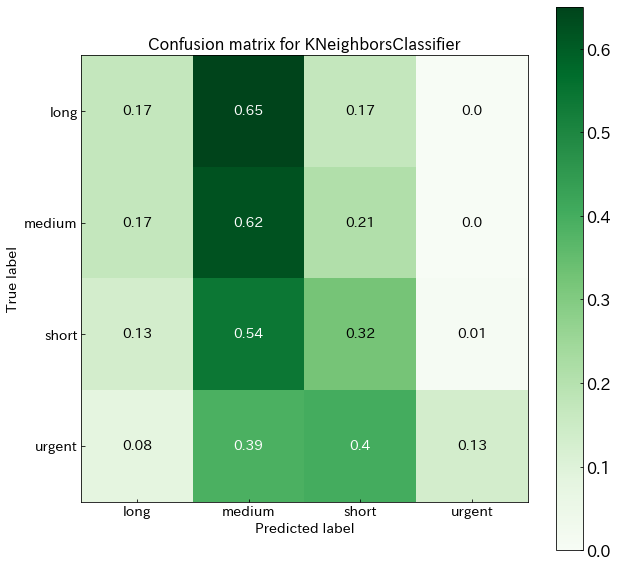

In [39]:
plot_conf_matrix(test_scaled, model=knn_clf, selected_cols=selected_sensors, target_col="EngineCondition")

In [40]:
def evaluation_model(test_df, model, selected_cols, target_col):    
    
    # making a prediction
    X_test = test_df[selected_cols]
    y_test = test_df[target_col]
                     
    y_preds = model.predict(X_test)
    y_probs = model.predict_proba(X_test)
    
    # evaluating model
    print("=" * 60)
    print("Evaluation metrics: ")
    print(f"Classification report:\n {metrics.classification_report(y_test, y_preds)}")
    print(f"Accuracy score: {metrics.accuracy_score(y_test, y_preds):.2f}")
    print("=" * 60)

In [41]:
evaluation_model(test_scaled, model=knn_clf, selected_cols=selected_sensors, target_col="EngineCondition")

Evaluation metrics: 
Classification report:
               precision    recall  f1-score   support

        long       0.03      0.17      0.05       243
      medium       0.21      0.62      0.31      2175
       short       0.42      0.32      0.36      5652
      urgent       0.95      0.13      0.22      5026

    accuracy                           0.29     13096
   macro avg       0.40      0.31      0.24     13096
weighted avg       0.58      0.29      0.29     13096

Accuracy score: 0.29
